# Extended Kalman filter for 3 DOF linear model
An Extended Kalman filter with a 3 DOF linear model as the predictor will be developed.
The filter is run on simulated data as well as real model test data.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import sympy as sp

import src.visualization.book_format as book_format
book_format.set_style()
from src.substitute_dynamic_symbols import lambdify
from sympy import Matrix
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify
from sympy.physics.vector.printing import vpprint, vlatex
from src.data import mdl
from src.kalman_filter import extended_kalman_filter
import src.models.vmm_nonlinear_EOM  as vmm
from docs.book.example_1 import ship_parameters, df_parameters
from src.symbols import *
from src import prime_system
p = df_parameters["symbol"]
from src.visualization.plot import track_plot, plot

import matplotlib.pyplot as plt
import os
if os.name == 'nt':
    plt.style.use('../docs/book/book.mplstyle')  # Windows

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')
C:\Dev\wPCC\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 3DOF model

In [2]:
X_eq = vmm.X_eq
Y_eq = vmm.Y_eq
N_eq = vmm.N_eq

A, b = sp.linear_eq_to_matrix([X_eq, Y_eq, N_eq], [u1d, v1d, r1d])

acceleration = sp.matrices.MutableDenseMatrix([u1d,v1d,r1d])
eq_simulator = sp.Eq(sp.UnevaluatedExpr(A)*sp.UnevaluatedExpr(acceleration),sp.UnevaluatedExpr(b))
eq_simulator

Eq(Matrix([
[-X_{\dot{u}} + m,                    0,                    0],
[               0,     -Y_{\dot{v}} + m, -Y_{\dot{r}} + m*x_G],
[               0, -N_{\dot{v}} + m*x_G,    I_z - N_{\dot{r}}]])*Matrix([
[\dot{u}],
[\dot{v}],
[\dot{r}]]), Matrix([
[-m*(-r**2*x_G - r*v) + X_D(u, v, r, delta)],
[              -m*r*u + Y_D(u, v, r, delta)],
[          -m*r*u*x_G + N_D(u, v, r, delta)]]))

In [3]:
A_inv = A.inv()
S = sp.symbols('S')
eq_S=sp.Eq(S,-sp.fraction(A_inv[1,1])[1])

A_inv_S = A_inv.subs(eq_S.rhs,S)
eq_acceleration_matrix_clean = sp.Eq(sp.UnevaluatedExpr(acceleration),sp.UnevaluatedExpr(A_inv_S)*sp.UnevaluatedExpr(b))
Math(vlatex(eq_acceleration_matrix_clean))

<IPython.core.display.Math object>

In [4]:
u1d_function = sp.Function(r'\dot{u}')(u,v,r,delta)
v1d_function = sp.Function(r'\dot{v}')(u,v,r,delta)
r_function = sp.Function(r'\dot{r}')(u,v,r,delta)

subs_prime = [
    
    (m,m/prime_system.df_prime.mass.denominator),
    (I_z,I_z/prime_system.df_prime.inertia_moment.denominator),
    (x_G,x_G/prime_system.df_prime.length.denominator),
    
    (u, u/sp.sqrt(u**2+v**2)),
    (v, v/sp.sqrt(u**2+v**2)),
    (r, r/(sp.sqrt(u**2+v**2)/L)),
   
]

subs = [
(X_D, vmm.X_qs_eq.rhs),
(Y_D, vmm.Y_qs_eq.rhs),
(N_D, vmm.N_qs_eq.rhs),
]

subs = subs + subs_prime

A_SI = A.subs(subs)
b_SI = b.subs(subs)

x_dot = sympy.matrices.dense.matrix_multiply_elementwise(A_SI.inv()*b_SI,
                                                 sp.Matrix([(u**2+v**2)/L,(u**2+v**2)/L,(u**2+v**2)/(L**2)]))


In [5]:
x_ = sp.Matrix([u*sp.cos(psi)-v*sp.sin(psi),
                                u*sp.sin(psi)+v*sp.cos(psi),
                                r])

f_ = sp.Matrix.vstack(x_, x_dot)

subs = {value: key for key, value in p.items()}
subs[psi] = sp.symbols('psi')
lambda_f = lambdify(f_.subs(subs))

In [6]:
def lambda_f_constructor(parameters, ship_parameters):
    
    def f(x, u):
        delta = u
        
        psi=x[2]
        u=x[3]
        v=x[4]
        r=x[5]
        
        x_dot = run(lambda_f, **parameters, **ship_parameters, psi=psi, u=u, v=v, r=r, delta=delta).reshape(x.shape)
        return x_dot
    
    return f

## Simulation

In [7]:
def time_step(x_,u_):
    psi=x_[2]
    u=x_[3]
    v=x_[4]
    r=x_[5]
    delta = u_
    x_dot = run(lambda_f, **parameters, **ship_parameters, psi=psi, u=u, v=v, r=r, delta=delta).flatten()
    return x_dot

def simulate(x0,E, ws, t, us):
    
    simdata = np.zeros((6,len(t)))
    x_=x0
            
    for i,(u_,w_) in enumerate(zip(us,ws)):
       
        x_dot = lambda_f_(x_,u_)
        
        x_=x_ + h_*x_dot
        
        simdata[:,i] = x_.flatten()
                
    df = pd.DataFrame(simdata.T, columns=["x0","y0","psi","u","v","r"], index=t)
    df.index.name = 'time'
    df['delta'] = us
    
    return df

In [8]:
parameters=df_parameters['prime'].copy()

lambda_f_ = lambda_f_constructor(parameters=parameters, 
                                               ship_parameters=ship_parameters)

N_ = 4000

t_ = np.linspace(0,50,N_)
h_ = float(t_[1]-t_[0])

us = np.deg2rad(30*np.concatenate((-1*np.ones(int(N_/4)),
                                1*np.ones(int(N_/4)),
                                -1*np.ones(int(N_/4)),
                                1*np.ones(int(N_/4)))))

np.random.seed(42)
E = np.array([[0, 1]]).T
process_noise = np.deg2rad(0.01)
ws = process_noise*np.random.normal(size=N_)
x0_ = np.array([[0,0,0,3,0,0]]).T
df = simulate(x0=x0_, E=E, ws=ws, t=t_, us=us)

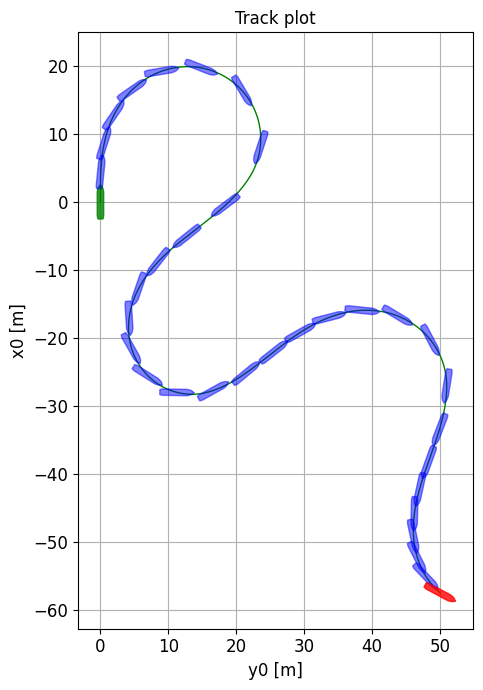

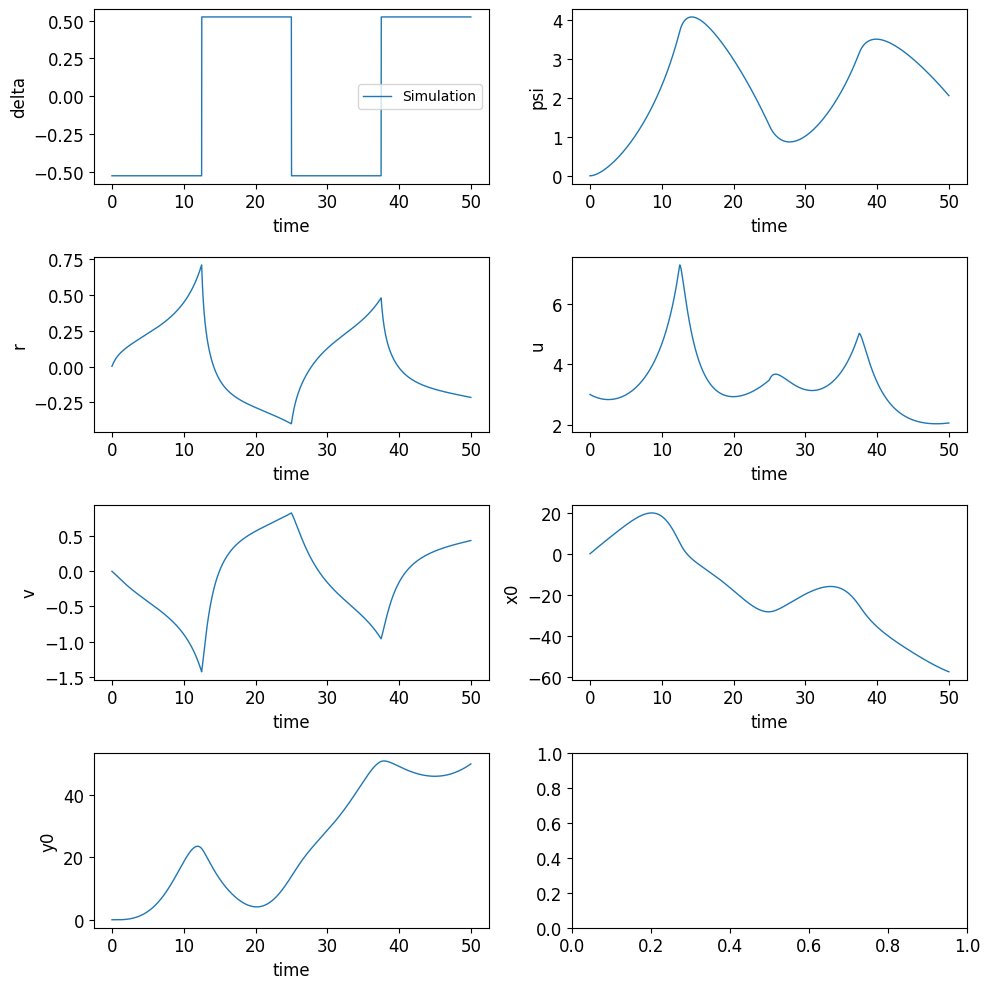

In [9]:
track_plot(
            df=df,
            lpp=ship_parameters["L"],
            beam=ship_parameters["B"],
            color="green",
        );

plot({'Simulation':df});

## Kalman filter
Implementation of the Kalman filter. The code is inspired of this Matlab implementation: [ExEKF.m](https://github.com/cybergalactic/MSS/blob/master/mssExamples/ExEKF.m).

In [10]:
x, x1d = sp.symbols(r'\vec{x} \dot{\vec{x}}')  # State vector
h = sp.symbols('h')
u_input = sp.symbols(r'u_{input}')  # input vector
w_noise = sp.symbols(r'w_{noise}')  # input vector

f = sp.Function('f')(x,u_input,w_noise)
eq_system = sp.Eq(x1d, f)
eq_system

Eq(\dot{\vec{x}}, f(\vec{x}, u_{input}, w_{noise}))

In [11]:
eq_x = sp.Eq(x, sp.UnevaluatedExpr(sp.Matrix([x_0, y_0, psi, u, v, r])))
eq_x

Eq(\vec{x}, Matrix([
[ x_0],
[ y_0],
[\Psi],
[   u],
[   v],
[   r]]))

In [12]:
jac = sp.eye(6,6) + f_.jacobian(eq_x.rhs.doit())*h
subs = {value: key for key, value in p.items()}
subs[psi] = sp.symbols('psi')
lambda_jacobian = lambdify(jac.subs(subs))

In [13]:
lambda_jacobian

<function _lambdifygenerated(I_z, L, Ndelta, Nr, Nrdot, Nu, Nur, Nv, Nvdot, Xdelta, Xr, Xrr, Xu, Xudot, Xv, Xvr, Ydelta, Yr, Yrdot, Yu, Yur, Yv, Yvdot, delta, h, m, psi, r, rho, u, v, x_G)>

In [14]:
def lambda_jacobian_constructor(parameters, ship_parameters, h):
    
    def f(x, u):
        delta = u
        
        psi=x[2]
        u=x[3]
        v=x[4]
        r=x[5]
        
        jacobian = run(lambda_jacobian, **parameters, **ship_parameters, psi=psi, u=u, v=v, r=r, delta=delta, h=h)
        return jacobian
    
    return f      

In [15]:
lambda_jacobian_ = lambda_jacobian_constructor(parameters=parameters, 
                                               ship_parameters=ship_parameters, h=h_)

In [16]:
df_measure = df.copy()

measurement_noise_psi_max = 3
measurement_noise_psi = np.deg2rad(measurement_noise_psi_max/3)
epsilon_psi = np.random.normal(scale=measurement_noise_psi, size=N_)

measurement_noise_xy_max=2
measurement_noise_xy = measurement_noise_xy_max/3
epsilon_x0 = np.random.normal(scale=measurement_noise_xy, size=N_)
epsilon_y0 = np.random.normal(scale=measurement_noise_xy, size=N_)

df_measure['psi'] = df['psi'] + epsilon_psi
df_measure['x0'] = df['x0'] + epsilon_x0
df_measure['y0'] = df['y0'] + epsilon_y0

In [23]:

P_prd = np.diag([0.1, 0.1, np.deg2rad(0.01), 0.001, 0.001, np.deg2rad(0.001)])
Qd = np.diag([0.01, 0.01, np.deg2rad(0.1)])  #process variances: u,v,r
Rd = np.diag([measurement_noise_xy**2, measurement_noise_xy**2, measurement_noise_psi**2])  #measurement variances: x0,y0,psi

ys = df_measure[['x0','y0','psi']].values

x0_ = np.array([[0,0,0,3,0,0]]).T

Cd = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
])

E = np.array([
    [0,0,0],
    [0,0,0],
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1],
    ],
)


time_steps = extended_kalman_filter(
                                    no_states=6,
                                    no_measurement_states=3,
                                    x0=x0_,
                                    P_prd=P_prd, 
                                    lambda_f=lambda_f_, 
                                    lambda_jacobian=lambda_jacobian_,
                                    h=h_, 
                                    us=us, 
                                    ys=ys, 
                                    E=E, 
                                    Qd=Qd, 
                                    Rd=Rd, 
                                    Cd=Cd)

x_hats = np.array([time_step["x_hat"] for time_step in time_steps]).T
time = np.array([time_step["time"] for time_step in time_steps]).T
Ks = np.array([time_step["K"] for time_step in time_steps]).T
variances = np.array([np.diagonal(time_step["P_hat"]) for time_step in time_steps]).T
stds = np.sqrt(variances)

(0.0, 0.01707211092315607)

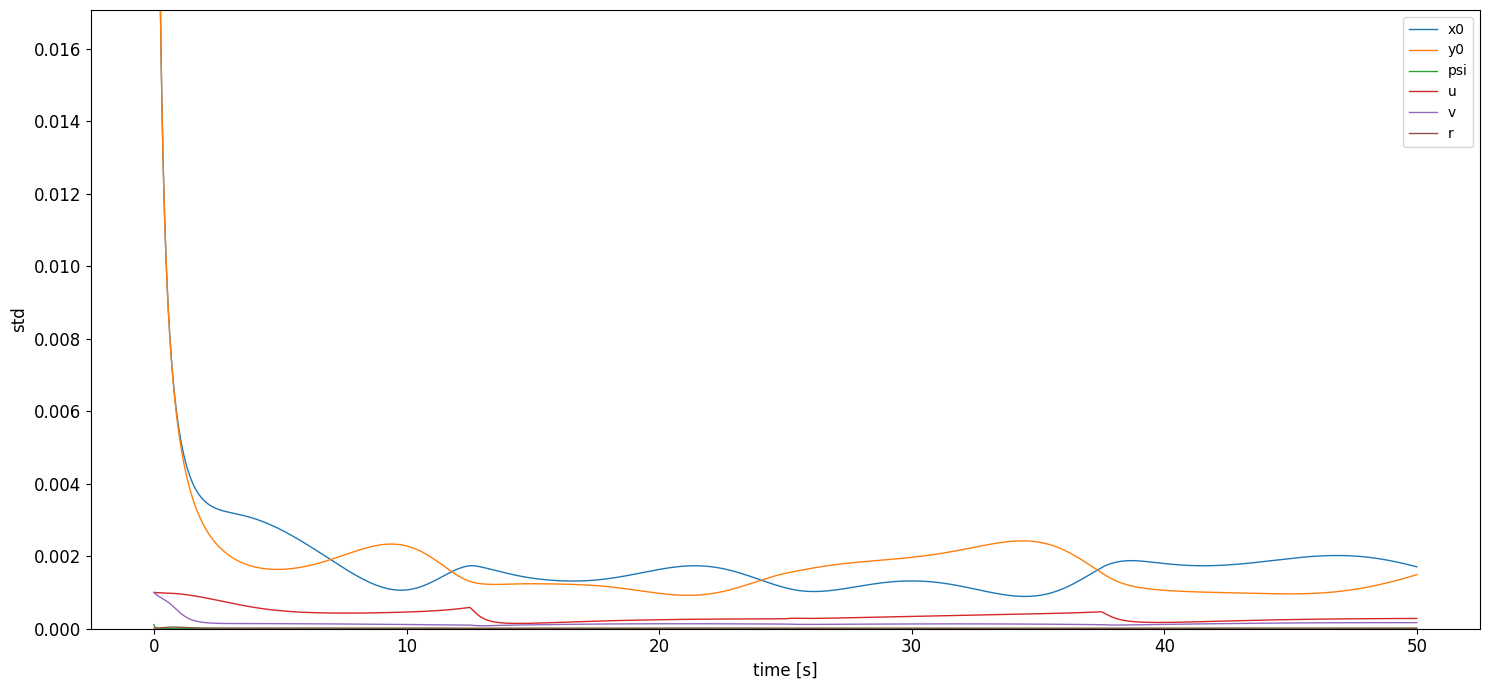

In [19]:
keys = ['x0','y0','psi','u','v','r']
fig,ax=plt.subplots()
for i,key in enumerate(keys):
    ax.plot(time, variances[i,:], label=key)
    
ax.legend()
ax.set_ylabel('std')
ax.set_xlabel('time [s]')
ax.set_ylim(0,10*np.max(variances[:,-1]))


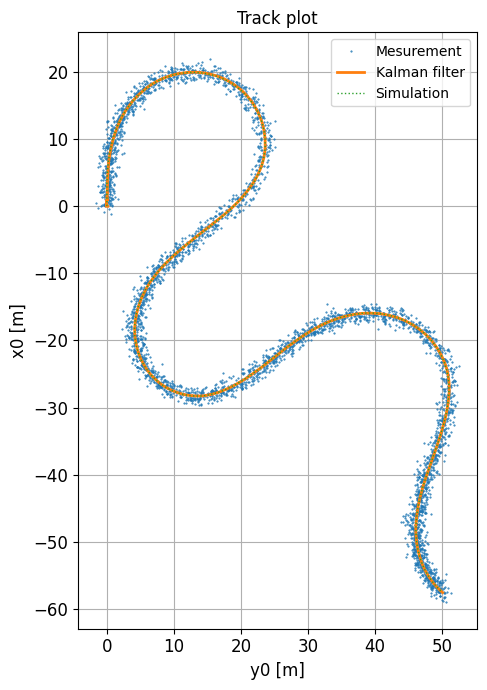

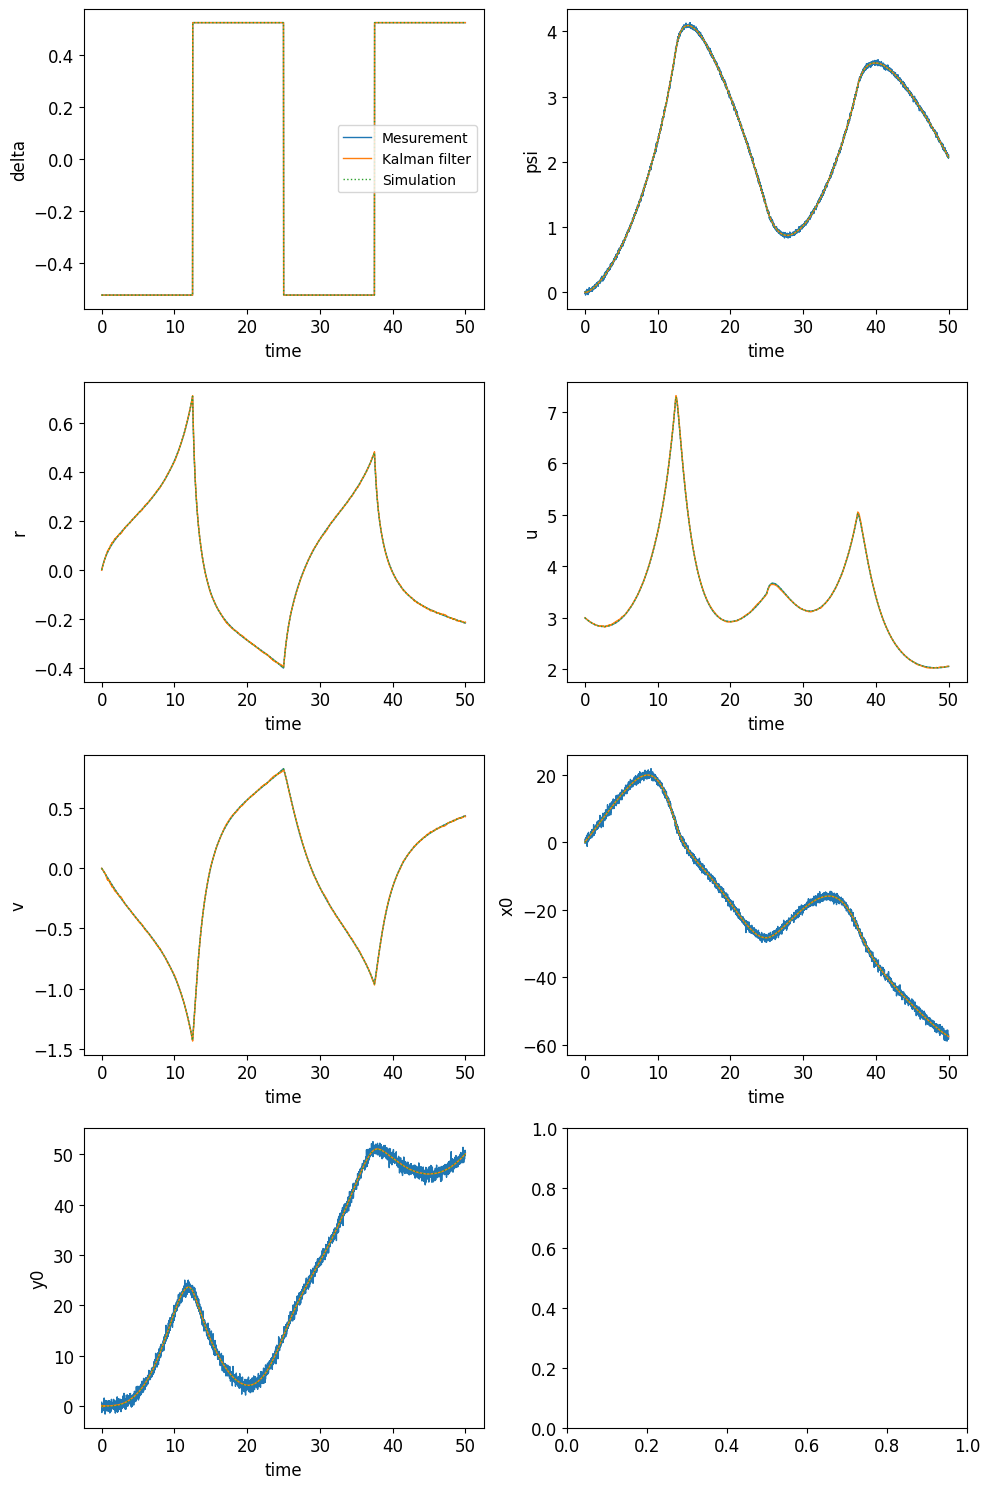

In [20]:
df_kalman = pd.DataFrame(data=x_hats.T, index=time, columns=['x0','y0','psi','u','v','r'])
df_kalman['delta'] = us

dataframes = {
    'Mesurement' : df_measure,
    'Kalman filter' : df_kalman,
    'Simulation' : df,
}

fig,ax=plt.subplots()
styles = {
    'Mesurement' : {
        'linestyle' : '',
        'marker' : '.',
        'ms' : 1,
    },
    
    'Kalman filter' : {
        'lw' : 2,
    },
    
    'Simulation' : {
        'lw' : 1,
        'linestyle' : ':',
    },
    
}

for label,df_ in dataframes.items():
    track_plot(
            df=df_,
            lpp=ship_parameters["L"],
            beam=ship_parameters["B"],
            ax=ax,
            label=label,
            plot_boats=False,
            **styles.get(label,{})
        );
ax.legend()


plot(dataframes = dataframes, fig_size=(10,15), styles = ['-','-',':']);

In [ ]:
P_prd = np.diag([0.1, 0.1, np.deg2rad(0.01), 0.001, 0.001, np.deg2rad(0.001)])
Qd = np.diag([0.01, 0.01, np.deg2rad(0.001)])
#Qd = np.diag([0.0, 0.0, 0])
#Rd = 0.1
Rd = np.diag([measurement_noise_xy**2, measurement_noise_xy**2, measurement_noise_psi**2])

ys = df_measure[['x0','y0','psi']].values

x0_ = np.array([[0,0,0,3,0,0]]).T

Cd = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
])

E = np.array([
    [0,0,0],
    [0,0,0],
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1],
    ],
)

x_prd = x0_
no_states = len(x_prd)

h=h_
Ed = h * E

for i in range(2):

    u = us[i]  # input
    y = np.array([ys[i]]).T  # measurement

    # Compute kalman gain:
    # S = Cd @ P_prd @ Cd.T + Rd  # System uncertainty
    # K = P_prd @ Cd.T @ inv(S)
    K = P_prd @ Cd.T @ inv(Cd @ P_prd @ Cd.T + Rd)
    IKC = np.eye(no_states) - K @ Cd

    ## State corrector:
    P_hat = IKC @ P_prd @ IKC.T + K @ Rd @ K.T
    eps = y - Cd @ x_prd
    x_hat = x_prd + K @ eps

    ## discrete-time extended KF-model
    f_hat = lambda_f_(x=x_hat, u=u)

    ## Predictor (k+1)
    ## Ad = I + h * A and Ed = h * E
    ## where A = df/dx is linearized about x = x_hat
    Ad = lambda_jacobian_(x=x_hat.flatten(), u=u)

    x_prd = x_hat + h * f_hat
    P_prd = Ad @ P_hat @ Ad.T + Ed @ Qd @ Ed.T

In [ ]:
K

In [ ]:
f_hat